In [1]:
from zlib import crc32
import numpy as np

if __name__=='__main__':
    mail = input('Enter phystech e-mail\n') 
    seed = crc32(mail.strip().encode('utf-8'))%(2**32 - 1)
    rs = np.random.RandomState(seed)
    print('Your tasks are:')
    print(
        '1.{}, 2.{}, 3.{}, 4.{}, 5.{}, 6.{}'.format(
            rs.randint(low=1, high=5), 
            rs.randint(low=1, high=5), 
            rs.randint(low=1, high=5), 
            rs.randint(low=1, high=4), 
            rs.randint(low=1, high=3), 
            rs.randint(low=1, high=3)))
# yurchenko.aa@phystech.edu

Enter phystech e-mail
yurchenko.aa@phystech.edu
Your tasks are:
1.1, 2.3, 3.3, 4.2, 5.2, 6.1


### Задача 1.1
Проверить мощность и консервативность критериев Лиллиефорса, Харке-Бера, Шапиро-Улика для выборок из следующих распределений:
* Нормальное
* Лапласа
* Стьюдента
* Усеченное нормальное распределение (модуль каждого элемента выборки не превосходит 2)

In [2]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import jarque_bera, shapiro

In [3]:
def generator(gtype, iters, sample_size, df, trunc):
    
    if gtype=='norm':
        return [[lilliefors(data)[1],
                 jarque_bera(data)[1],
                 shapiro(data)[1]] for data in [st.norm.rvs(size=sample_size) for _ in range(iters)]]
    
    elif gtype=='laplace':
        return [[lilliefors(data)[1],
                 jarque_bera(data)[1],
                 shapiro(data)[1]] for data in [st.laplace.rvs(size=sample_size) for _ in range(iters)]]
    
    elif gtype=='student':
        return [[lilliefors(data)[1],
                 jarque_bera(data)[1],
                 shapiro(data)[1]] for data in [st.t.rvs(df=df, size=sample_size) for _ in range(iters)]]
    
    elif gtype=='truncnorm':
        return [[lilliefors(data)[1],
                 jarque_bera(data)[1],
                 shapiro(data)[1]] for data in [st.truncnorm.rvs(-trunc, trunc, size=sample_size) for _ in range(iters)]]

In [119]:
def plot_power(gtype, ptype='Power', iters=100, MAX_SAMP=300, step=10, df=1, trunc=2): 

    sample_sizes = range(10, MAX_SAMP+1, step)

    power_lilliefors, power_jarque_bera, power_shapiro = [], [], []

    for sample_size in sample_sizes:

        p_values = generator(gtype, iters, sample_size, df, trunc)

        p_values = np.array(p_values).T
        p_values_lilliefors, p_values_jarque_bera, p_values_shapiro = p_values[0], p_values[1], p_values[2]
        
        power_lilliefors.append(len(p_values_lilliefors[p_values_lilliefors < 0.05]) / iters)
        power_jarque_bera.append(len(p_values_jarque_bera[p_values_jarque_bera < 0.05]) / iters)
        power_shapiro.append(len(p_values_shapiro[p_values_shapiro < 0.05]) / iters)
        

    fig, axes = plt.subplots(figsize=(16, 10))

    axes.plot(sample_sizes, power_lilliefors, sample_sizes, power_jarque_bera, sample_sizes, power_shapiro)
    if ptype == 'Power':
        axes.axhline(y = 1, color='r', linestyle='--')
    else:
        axes.axhline(y = 0.05, color='r', linestyle='--')    
        
    axes.legend(['Lilliefors', 'Jarque-Bera', 'Shapiro'], fontsize = 15)
    axes.set_xlabel('Sample size', fontsize = 15)
    axes.set_ylabel(ptype, fontsize = 15)
    
    if gtype=='student':
        comment = ' with df = ' + str(df)
    elif gtype=='truncnorm':
        comment = ' with trunc = ' + str(trunc)   
    else:
        comment = ''
        
    axes.set_title(str.upper(gtype) + ' distribution' + comment, fontsize = 18)
    #ptype + ' from sample size for ' + 

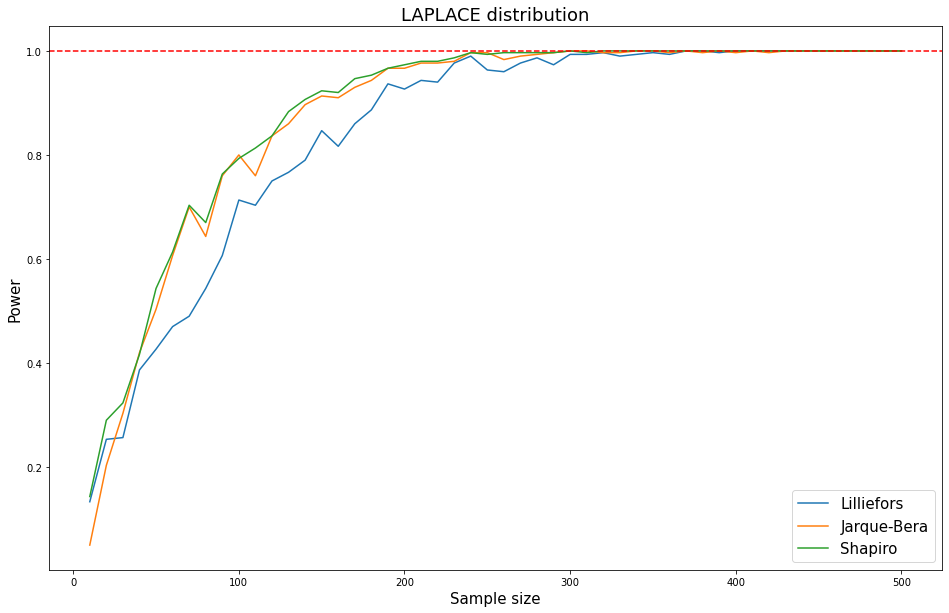

In [120]:
plot_power('laplace', iters=300, MAX_SAMP=500)

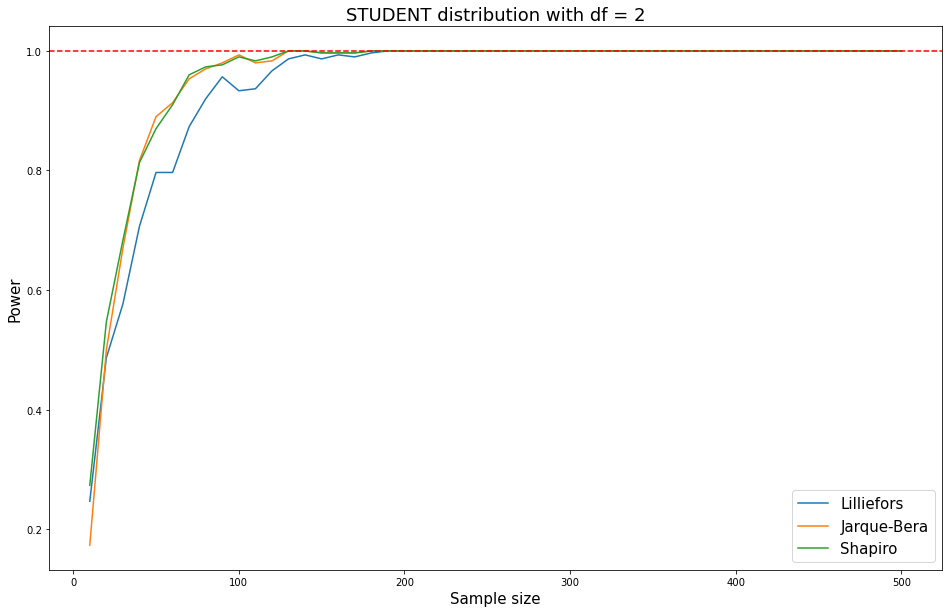

In [121]:
plot_power('student', iters=300, MAX_SAMP=500, df=2)

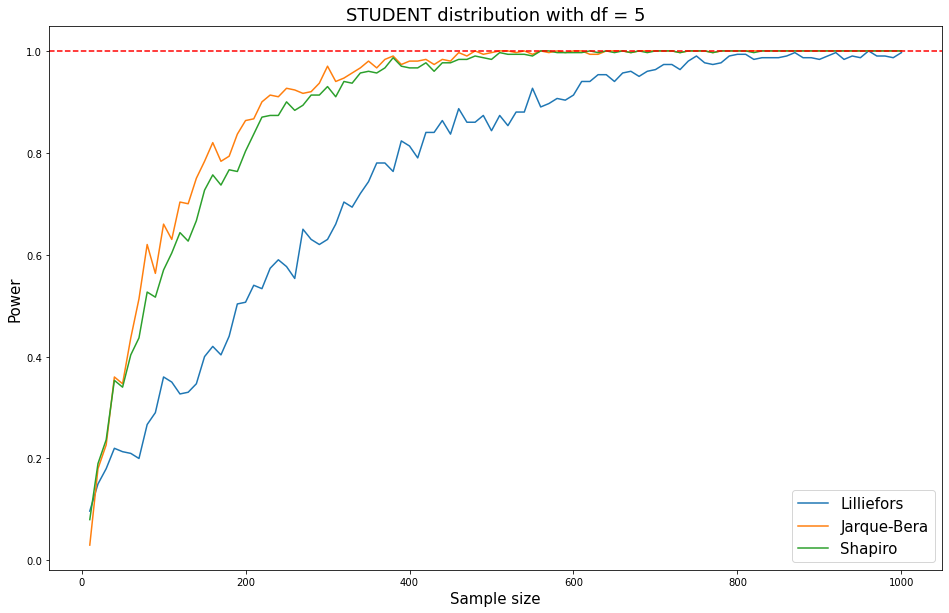

In [122]:
plot_power('student', iters=300, MAX_SAMP=1000, df=5)

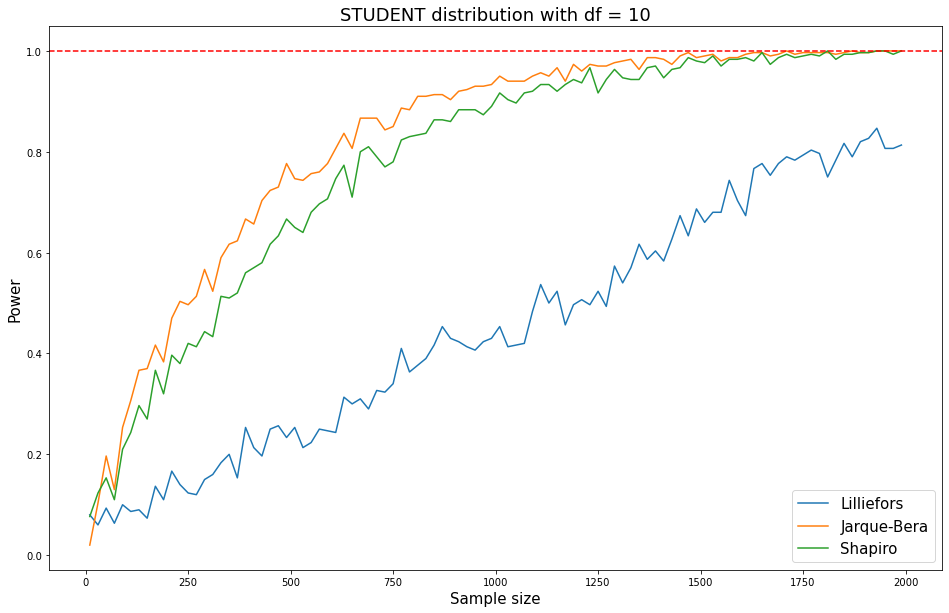

In [123]:
plot_power('student', iters=300, MAX_SAMP=2000, step=20, df=10)

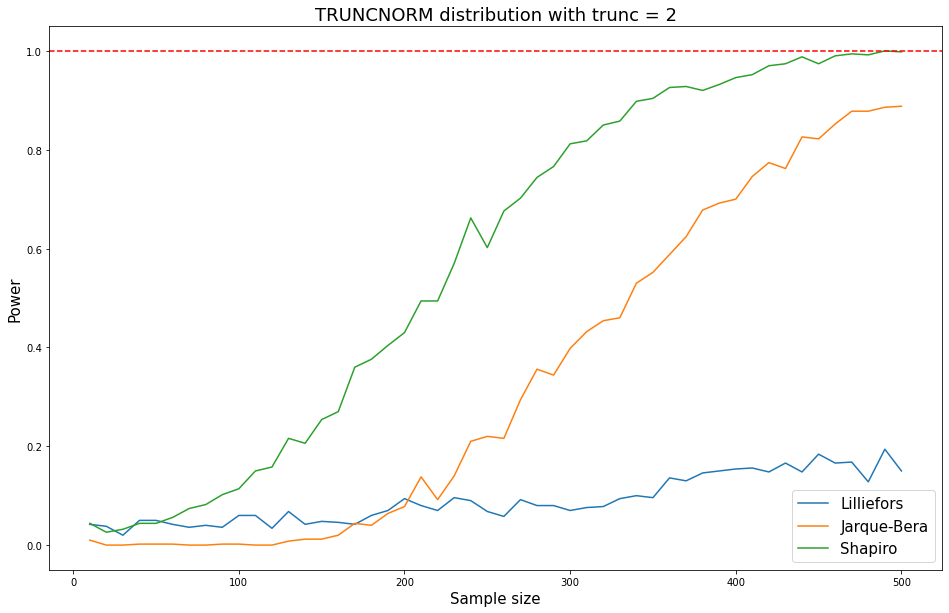

In [124]:
plot_power('truncnorm', iters=500, MAX_SAMP=500, trunc=2)

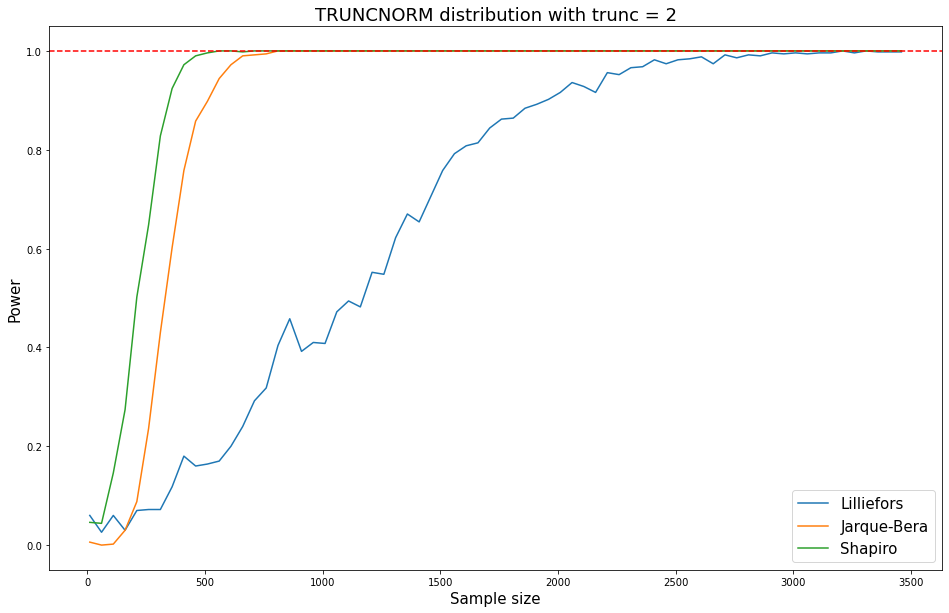

In [125]:
plot_power('truncnorm', iters=500, MAX_SAMP=3500, step=50, trunc=2)

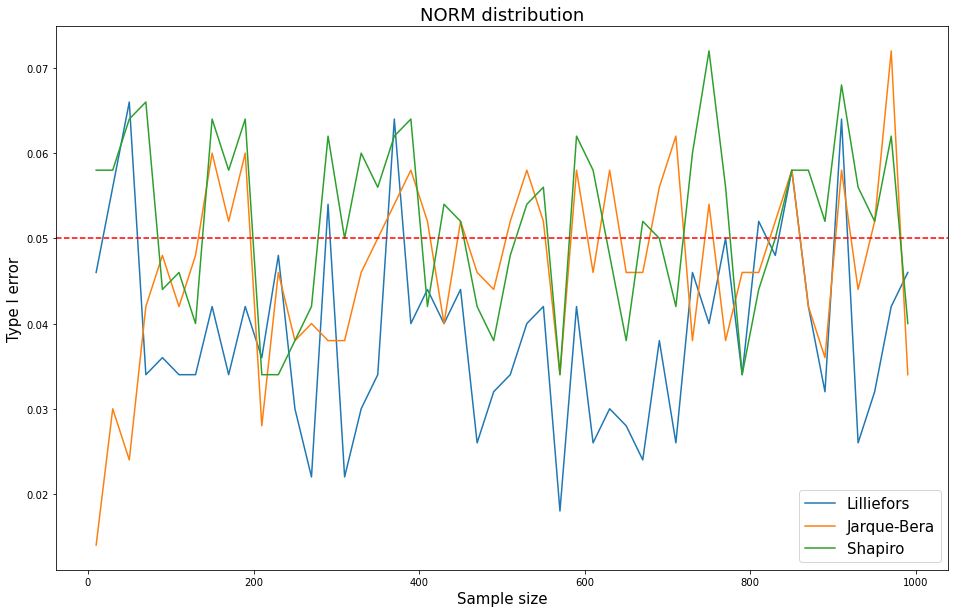

In [126]:
plot_power('norm', ptype='Type I error', iters=500, step=20, MAX_SAMP=1000)

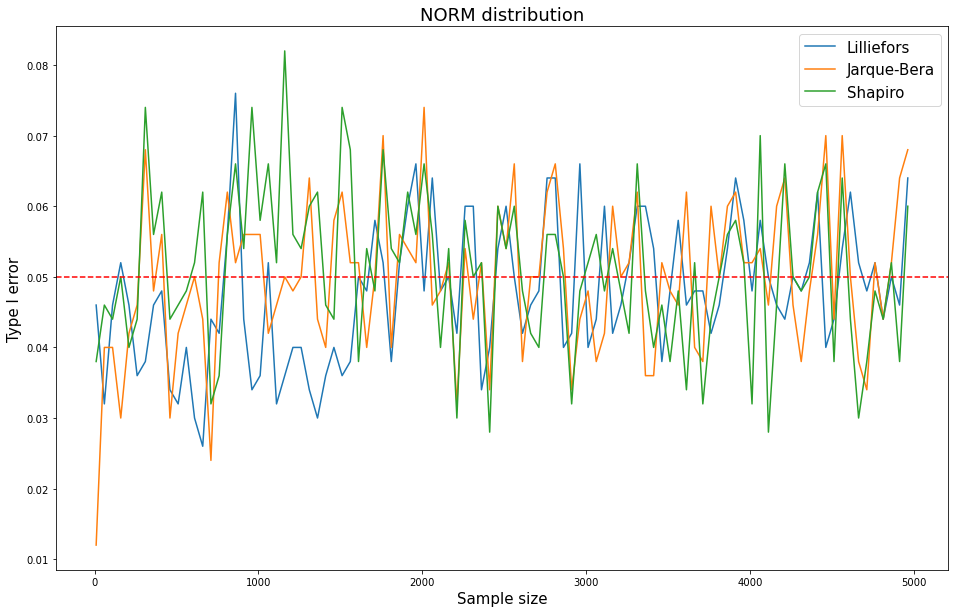

In [127]:
plot_power('norm', ptype='Type I error', iters=500, step=50, MAX_SAMP=5000)

### Задача 2.3
Известно, что электричка "Вашингтон-Петушки" аварийно останавливается раз в несколько дней. Аналитики РЖД проанализировали, сколько дней электричка едет без поломок, и составили выборку: $x = (3, 22, 13, 6, 18, 5, 6, 10, 7, 15)$.

РЖД хочет проверить гипотезу, что дисперсия распределения равна $9$ против правосторонней альтернативы.

Требуется:

Ввести предположение, каким распределением описывается данная выборка.
Записать задачу формально.
* Предложить критерий для оценки дисперсии распределения.
* Проверить гипотезу о значении дисперсии распределения для уровня значимости $\alpha = 0.05$ аналитически.
* Вывести и получить доверительный интервал для значения дисперсии при $\alpha = 0.05$.

Все выкладки должны быть сделаны аналитически, без использования компьютера. (допускается использование компютера для  подстановвки численых значений в финальную формулу)

In [6]:
import seaborn as sns
import numpy as np 
import pylab
import matplotlib.pyplot as plt 
import scipy.stats as stats

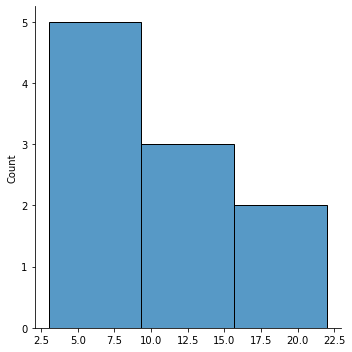

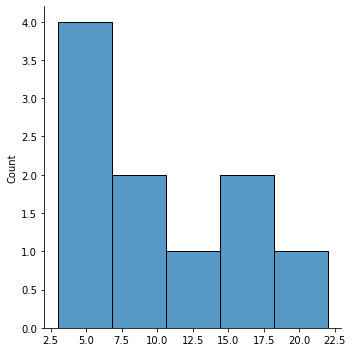

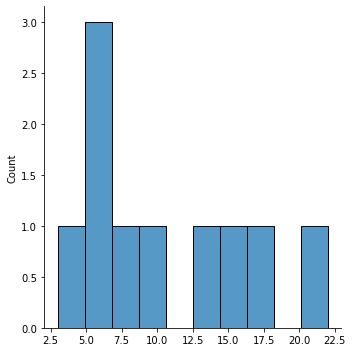

In [7]:
x = [3, 22, 13, 6, 18, 5, 6, 10, 7, 15]
_ = sns.displot(x, bins=3) 
_ = sns.displot(x) 
_ = sns.displot(x, bins=len(x))

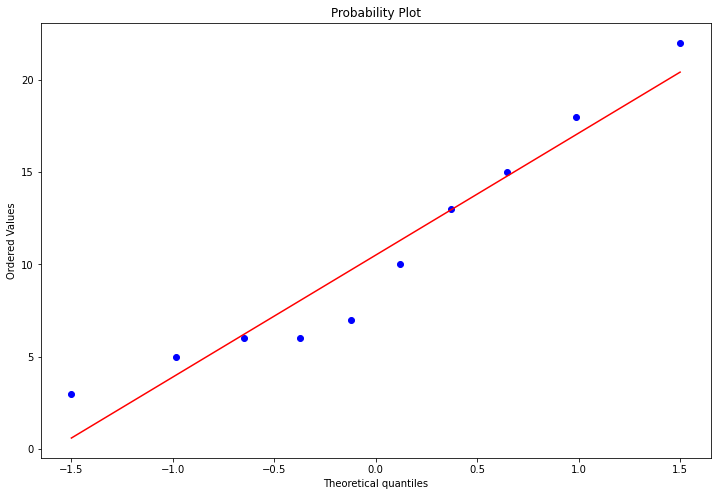

In [8]:
plt.figure(figsize=(12, 8))
_ = stats.probplot(x, dist="norm", plot=pylab)

Предположение: данная выборка описывается нормальным распределением 

### Задача 3.3
Предложить метод выбора наиболее важных признаков для логистической регрессии на основе изученных методов прикладной статистики. Осуществить выбор.

In [9]:
import pandas as pd
import numpy as np
import scipy.stats as st

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.datasets import load_wine

import statsmodels.api as sm

from statsmodels.formula.api import ols

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from statsmodels.stats.weightstats  import ttest_ind

In [10]:
wine = load_wine()

featute_cols = wine['feature_names']
X_wine = pd.DataFrame(wine['data'], columns =  featute_cols)
y_wine = wine['target']

df_wine = X_wine
df_wine['target'] = y_wine
df_wine.rename(columns = {'od280/od315_of_diluted_wines':'od280'}, inplace=True)
df_wine.sample(10).sort_index()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280,proline,target
29,14.02,1.68,2.21,16.0,96.0,2.65,2.33,0.26,1.98,4.70,1.04,3.59,1035.0,0
100,12.08,2.08,1.70,17.5,97.0,2.23,2.17,0.26,1.40,3.30,1.27,2.96,710.0,1
104,12.51,1.73,1.98,20.5,85.0,2.20,1.92,0.32,1.48,2.94,1.04,3.57,672.0,1
106,12.25,1.73,2.12,19.0,80.0,1.65,2.03,0.37,1.63,3.40,1.00,3.17,510.0,1
111,12.52,2.43,2.17,21.0,88.0,2.55,2.27,0.26,1.22,2.00,0.90,2.78,325.0,1
118,12.77,3.43,1.98,16.0,80.0,1.63,1.25,0.43,0.83,3.40,0.70,2.12,372.0,1
154,12.58,1.29,2.10,20.0,103.0,1.48,0.58,0.53,1.40,7.60,0.58,1.55,640.0,2
166,13.45,3.70,2.60,23.0,111.0,1.70,0.92,0.43,1.46,10.68,0.85,1.56,695.0,2
168,13.58,2.58,2.69,24.5,105.0,1.55,0.84,0.39,1.54,8.66,0.74,1.80,750.0,2
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2


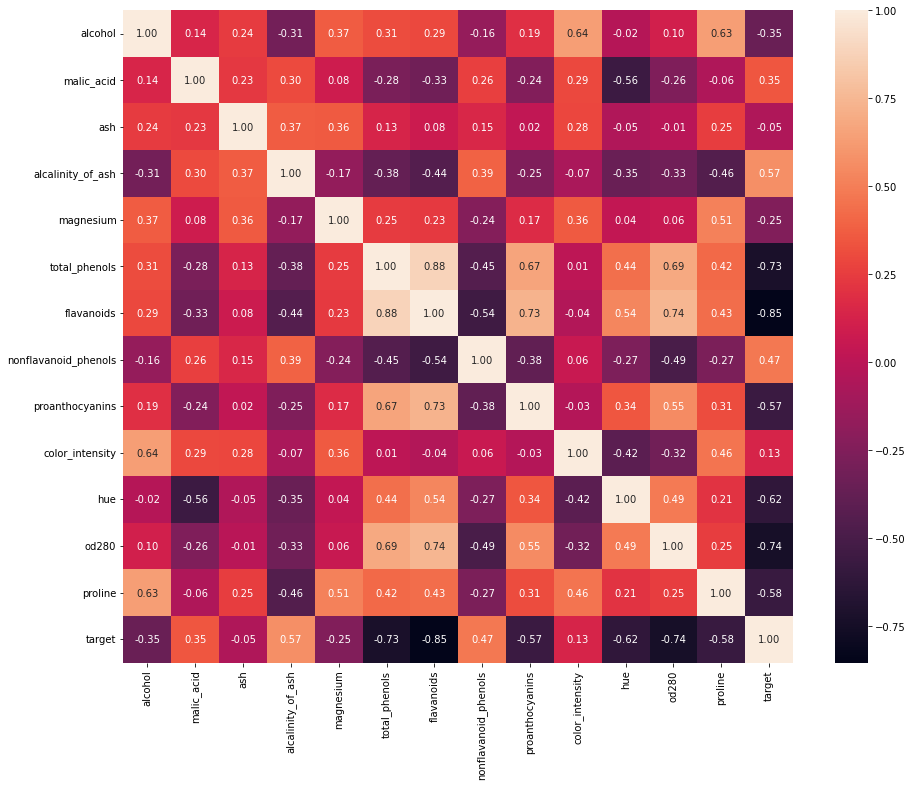

In [11]:
plt.figure(figsize = (15, 12))
_ = sns.heatmap(df_wine.corr(method = 'spearman'), annot=True, fmt = '.2f')

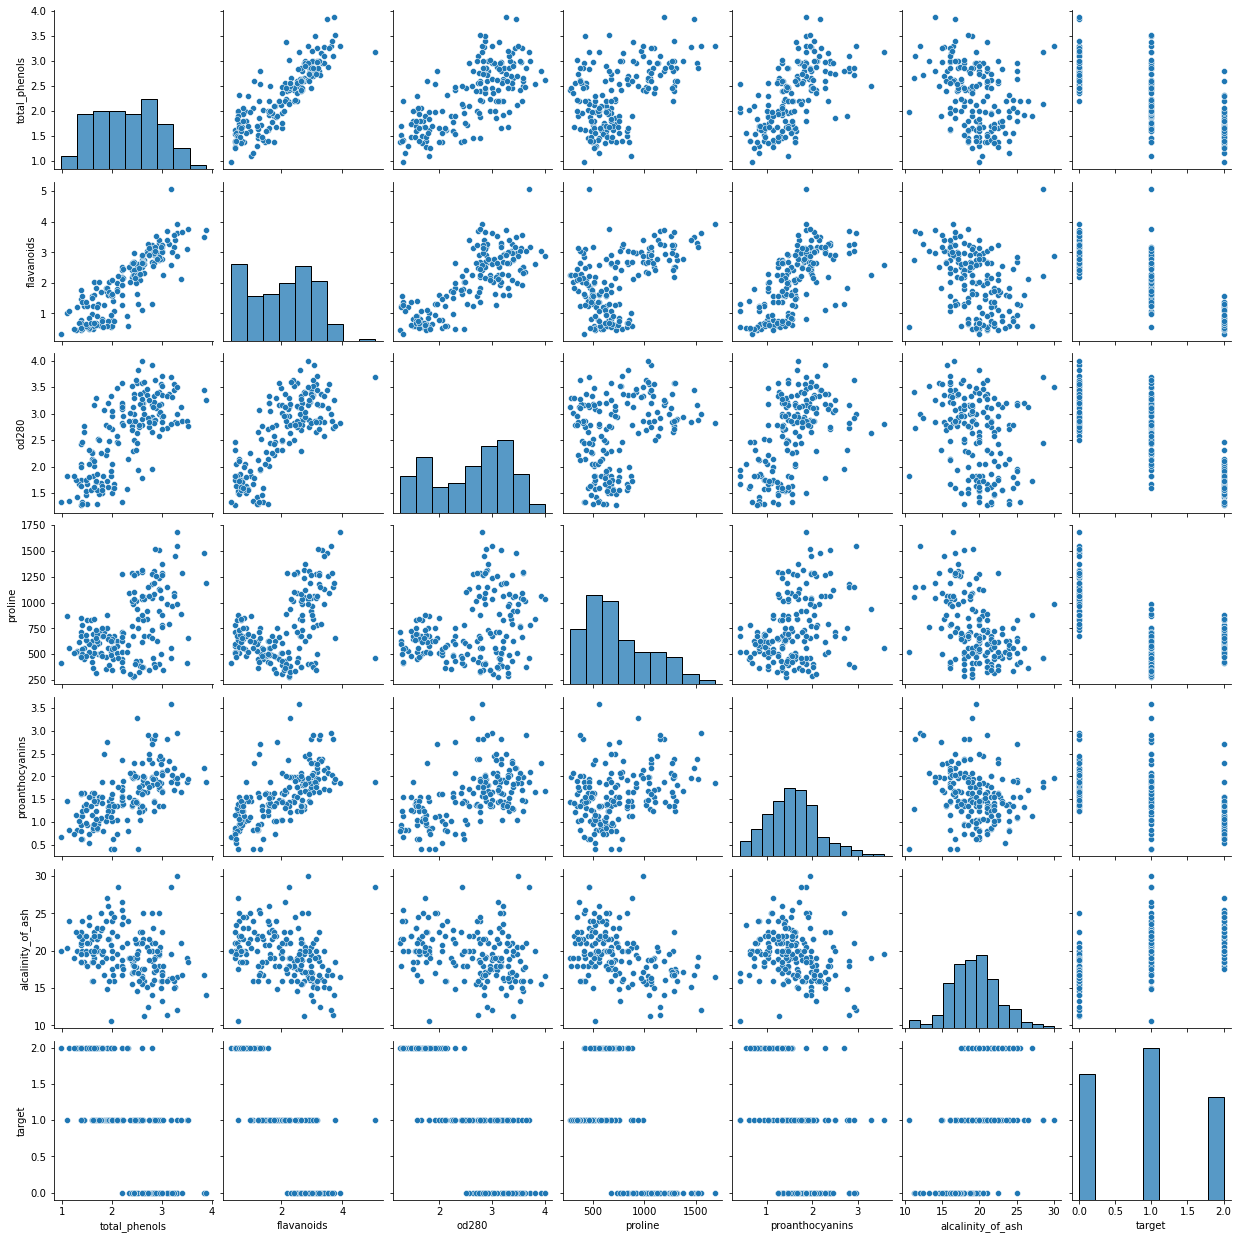

In [11]:
_ = sns.pairplot(df_wine[['total_phenols',
                          'flavanoids',
                          'od280',
                          'proline',
                          'proanthocyanins',
                          'alcalinity_of_ash',
                          'target']])

In [43]:
corr_matrix = df_wine.corr(method = 'spearman') \
                     .to_numpy(dtype = 'float64')

corr_matrix[-1]

array([-0.35416692,  0.34691327, -0.05398792,  0.56979214, -0.25049819,
       -0.72654365, -0.85490766,  0.47420549, -0.57064758,  0.13117017,
       -0.61657049, -0.7437869 , -0.57638313,  1.        ])

In [44]:
X = df_wine[featute_cols]
y = df_wine['target']

KeyError: "['od280/od315_of_diluted_wines'] not in index"

## New attempt

In [12]:
sorted_features = list(df_wine.corr()['target'].abs().sort_values(ascending = False).iloc[1:].index)
sorted_features

['flavanoids',
 'od280',
 'total_phenols',
 'proline',
 'hue',
 'alcalinity_of_ash',
 'proanthocyanins',
 'nonflavanoid_phenols',
 'malic_acid',
 'alcohol',
 'color_intensity',
 'magnesium',
 'ash']

In [27]:
lm = ols('target ~ flavanoids + \
                   od280 + \
                   total_phenols + \
                   proline + \
                   hue + \
                   alcalinity_of_ash + \
                   proanthocyanins + \
                   nonflavanoid_phenols + \
                   malic_acid + \
                   alcohol + \
                   magnesium + \
                   ash',
         data=df_wine).fit()

result = sm.stats.anova_lm(lm, typ=1)
# result[result['PR(>F)'] < 0.05].sort_values(by='PR(>F)')
result

,df,sum_sq,mean_sq,F,PR(>F)
flavanoids,1.0,76.364723,76.364723,1014.486318,2.252174e-72
od280,1.0,4.098629,4.098629,54.449269,7.413351e-12
total_phenols,1.0,0.164352,0.164352,2.183369,1.414150e-01
proline,1.0,8.887084,8.887084,118.062701,4.374917e-21
hue,1.0,1.874247,1.874247,24.898900,1.521357e-06
alcalinity_of_ash,1.0,1.936252,1.936252,25.722625,1.050729e-06
proanthocyanins,1.0,0.264866,0.264866,3.518675,6.244728e-02
nonflavanoid_phenols,1.0,0.141491,0.141491,1.879677,1.722328e-01
malic_acid,1.0,0.005268,0.005268,0.069982,7.916926e-01
alcohol,1.0,0.088258,0.088258,1.172479,2.804723e-01


In [28]:
from sklearn.feature_selection import f_classif
X = df_wine[featute_cols]
y = df_wine['target']
f_classif(X, y)

KeyError: "['od280/od315_of_diluted_wines'] not in index"

In [206]:
from sklearn.feature_selection import SelectKBest

fs = SelectKBest(score_func=f_classif, k=4)
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

(178, 4)


In [207]:
selector = SelectKBest(f_classif, k=5)
selector.fit(X, y)
cols = selector.get_support(indices=True)
features_df_new = X.iloc[:,cols]
features_df_new

,alcohol,flavanoids,color_intensity,od280/od315_of_diluted_wines,proline
0,14.23,3.06,5.64,3.92,1065.0
1,13.20,2.76,4.38,3.40,1050.0
2,13.16,3.24,5.68,3.17,1185.0
3,14.37,3.49,7.80,3.45,1480.0
4,13.24,2.69,4.32,2.93,735.0
...,...,...,...,...,...
173,13.71,0.61,7.70,1.74,740.0
174,13.40,0.75,7.30,1.56,750.0
175,13.27,0.69,10.20,1.56,835.0
176,13.17,0.68,9.30,1.62,840.0


In [208]:
from sklearn.feature_selection import mutual_info_classif
selector = SelectKBest(mutual_info_classif, k=2)
selector.fit(X, y)
cols = selector.get_support(indices=True)
features_df_new = X.iloc[:,cols]
features_df_new

,flavanoids,color_intensity
0,3.06,5.64
1,2.76,4.38
2,3.24,5.68
3,3.49,7.80
4,2.69,4.32
...,...,...
173,0.61,7.70
174,0.75,7.30
175,0.69,10.20
176,0.68,9.30


### Задача 4.2
Рассмотрим некоторую задачу классификации. Пусть задано качество 4 моделей $a_1, a_2, a_3, a_4$. Качество полученных моделей показано в таблице.

Исследователю требуется выбрать наилучшую модель. Для выбора лучшей модели исследовать требуется попарно сравнить среднее значение качества всех моделей. Может ли исследователь утверждать что какая-то из моделей лучше другой?

Требуется:

* записать задачу формально;
* предложить статистику для решения данной задачи;
* записать нулевое распределение данной статистики;
* записать явно правило принятия решения на основе статистики и нулевого распределения для обеспечения уровня значимости $\alpha = 0.05$;
* проверить гипотезу по записанному критерию, для данных из условия. Противоречат ли они гипотезе?

Все выкладки должны быть сделаны аналитически, без использования компьютера. (допускается использование компютера для подстановвки численых значений в финальную формулу)

In [1]:
import pandas as pd
classifiers = pd.read_csv('classifiers.csv', sep = ',', index_col = 'Номер выборки')
classifiers

,a1,a2,a3,a4
Номер выборки,,,,
1,86,50,93,13
2,85,74,55,35
3,53,92,58,51
4,44,41,56,37
5,2,18,99,26
6,5,68,35,17


In [2]:
classifiers.describe()

,a1,a2,a3,a4
count,6.000000,6.000000,6.000000,6.000000
mean,45.833333,57.166667,66.000000,29.833333
std,36.853313,26.309061,24.754798,14.062954
min,2.000000,18.000000,35.000000,13.000000
25%,14.750000,43.250000,55.250000,19.250000
50%,48.500000,59.000000,57.000000,30.500000
75%,77.000000,72.500000,84.250000,36.500000
max,86.000000,92.000000,99.000000,51.000000


### Задача 5.2

Требуется:

* Отобрать записи, соответствующие странам с минимум 30 респонеднтами в выборке
* Получить сумму zero-crossing по каждой из записей
* Провести ANOVA-анализ по аттрибутам родного языка, пола и возраста для уровня значимости $0.15$. Дискретность признака zero-crossing игнорировать.

In [ ]:
from zlib import crc32
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st

import statsmodels.api as sm

from statsmodels.formula.api import ols

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from statsmodels.stats.weightstats  import ttest_ind

In [29]:
import pandas as pd
speakers = pd.read_csv('speakers_all.csv')
speakers.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True,NaN,NaN,NaN
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True,NaN,NaN,NaN
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True,NaN,NaN,NaN
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True,NaN,NaN,NaN
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True,NaN,NaN,NaN


In [30]:
speakers.drop(speakers[speakers['file_missing?'] == True].index, inplace = True)
speakers.drop(['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'], axis = 1, inplace = True)

In [31]:
speakers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140 entries, 32 to 2171
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              2140 non-null   float64
 1   age_onset        2140 non-null   float64
 2   birthplace       2136 non-null   object 
 3   filename         2140 non-null   object 
 4   native_language  2140 non-null   object 
 5   sex              2140 non-null   object 
 6   speakerid        2140 non-null   int64  
 7   country          2135 non-null   object 
 8   file_missing?    2140 non-null   bool   
dtypes: bool(1), float64(2), int64(1), object(5)
memory usage: 152.6+ KB


In [32]:
query_res = speakers[['speakerid', 'country']].groupby('country', as_index = False) \
                                              .count() \
                                              .query('speakerid >= 30') \
                                              .sort_values('speakerid', ascending = False) 

country_names = list(query_res.country)

In [62]:
speakers = speakers.query("country in @country_names")
speakers.reset_index(drop=True, inplace=True)
speakers

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,zero_crossing_count,zero_crossing_sum
0,20.0,5.0,"addis ababa, ethiopia",amharic1,amharic,female,6,ethiopia,False,3286,212.073730
1,29.0,19.0,"gonder, ethiopia",amharic10,amharic,female,998,ethiopia,False,4137,177.070312
2,24.0,17.0,"addis ababa, ethiopia",amharic11,amharic,female,1129,ethiopia,False,2399,202.801758
3,26.0,15.0,"addis ababa, ethiopia",amharic12,amharic,female,1130,ethiopia,False,2257,150.427734
4,28.0,6.0,"addis ababa, ethiopia",amharic13,amharic,female,1131,ethiopia,False,2811,255.820801
...,...,...,...,...,...,...,...,...,...,...,...
1040,23.0,10.0,"zhuzhou, hunan, china",xiang4,xiang,female,2163,china,False,2338,206.517578
1041,19.0,13.0,"yakutsk, russia",yakut1,yakut,female,1252,russia,False,1679,108.870117
1042,78.0,6.0,"winnipeg, manitoba, canada",yiddish2,yiddish,female,405,canada,False,1893,151.707520
1043,52.0,5.0,"brooklyn, new york, usa",yiddish3,yiddish,male,1161,usa,False,2056,104.713867


In [129]:
import os
rec_dir = 'recordings/'
audio_names = os.listdir(rec_dir)

In [130]:
import IPython.display as ipd  
import librosa
import librosa.display

In [131]:
ipd.Audio(rec_dir + audio_names[3])

In [53]:
%%time
y, sr = librosa.load(rec_dir + audio_names[3], sr = 44100)
zc = librosa.feature.zero_crossing_rate(y)

print(zc.shape[1], zc.sum())

2022 100.1650390625
Wall time: 2.68 s


Код ниже выполняется порядка 45 минут. Поэтому результат его выполнения будет сохранён в файл speakers_with_zero_crossing.csv

In [56]:
%%time
zero_crossing_count = []
zero_crossing_sum = []

for i, audio_file in enumerate(speakers.filename):   
    y, sr = librosa.load(rec_dir + audio_file + '.mp3', sr = 44100)
    zc = librosa.feature.zero_crossing_rate(y)
    zero_crossing_count.append(zc.shape[1])
    zero_crossing_sum.append(zc.sum())
    if i % 25 == 0:
        print('I have processed {} files'.format(i))

I have processed 0 files
I have processed 25 files
I have processed 50 files
I have processed 75 files
I have processed 100 files
I have processed 125 files
I have processed 150 files
I have processed 175 files
I have processed 200 files
I have processed 225 files
I have processed 250 files
I have processed 275 files
I have processed 300 files
I have processed 325 files
I have processed 350 files
I have processed 375 files
I have processed 400 files
I have processed 425 files
I have processed 450 files
I have processed 475 files
I have processed 500 files
I have processed 525 files
I have processed 550 files
I have processed 575 files
I have processed 600 files
I have processed 625 files
I have processed 650 files
I have processed 675 files
I have processed 700 files
I have processed 725 files
I have processed 750 files
I have processed 775 files
I have processed 800 files
I have processed 825 files
I have processed 850 files
I have processed 875 files
I have processed 900 files
I have

In [63]:
speakers['zero_crossing_count'] = zero_crossing_count
speakers['zero_crossing_sum'] = zero_crossing_sum

speakers

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,zero_crossing_count,zero_crossing_sum
0,20.0,5.0,"addis ababa, ethiopia",amharic1,amharic,female,6,ethiopia,False,3286,212.073730
1,29.0,19.0,"gonder, ethiopia",amharic10,amharic,female,998,ethiopia,False,4137,177.070312
2,24.0,17.0,"addis ababa, ethiopia",amharic11,amharic,female,1129,ethiopia,False,2399,202.801758
3,26.0,15.0,"addis ababa, ethiopia",amharic12,amharic,female,1130,ethiopia,False,2257,150.427734
4,28.0,6.0,"addis ababa, ethiopia",amharic13,amharic,female,1131,ethiopia,False,2811,255.820801
...,...,...,...,...,...,...,...,...,...,...,...
1040,23.0,10.0,"zhuzhou, hunan, china",xiang4,xiang,female,2163,china,False,2338,206.517578
1041,19.0,13.0,"yakutsk, russia",yakut1,yakut,female,1252,russia,False,1679,108.870117
1042,78.0,6.0,"winnipeg, manitoba, canada",yiddish2,yiddish,female,405,canada,False,1893,151.707520
1043,52.0,5.0,"brooklyn, new york, usa",yiddish3,yiddish,male,1161,usa,False,2056,104.713867


In [64]:
speakers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1045 non-null   float64
 1   age_onset            1045 non-null   float64
 2   birthplace           1045 non-null   object 
 3   filename             1045 non-null   object 
 4   native_language      1045 non-null   object 
 5   sex                  1045 non-null   object 
 6   speakerid            1045 non-null   int64  
 7   country              1045 non-null   object 
 8   file_missing?        1045 non-null   bool   
 9   zero_crossing_count  1045 non-null   int64  
 10  zero_crossing_sum    1045 non-null   float64
dtypes: bool(1), float64(3), int64(2), object(5)
memory usage: 82.8+ KB


In [66]:
speakers.to_csv('speakers_with_zero_crossing.csv', index=False)

In [67]:
speakers_zc = pd.read_csv('speakers_with_zero_crossing.csv')
speakers_zc

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,zero_crossing_count,zero_crossing_sum
0,20.0,5.0,"addis ababa, ethiopia",amharic1,amharic,female,6,ethiopia,False,3286,212.073730
1,29.0,19.0,"gonder, ethiopia",amharic10,amharic,female,998,ethiopia,False,4137,177.070312
2,24.0,17.0,"addis ababa, ethiopia",amharic11,amharic,female,1129,ethiopia,False,2399,202.801758
3,26.0,15.0,"addis ababa, ethiopia",amharic12,amharic,female,1130,ethiopia,False,2257,150.427734
4,28.0,6.0,"addis ababa, ethiopia",amharic13,amharic,female,1131,ethiopia,False,2811,255.820801
...,...,...,...,...,...,...,...,...,...,...,...
1040,23.0,10.0,"zhuzhou, hunan, china",xiang4,xiang,female,2163,china,False,2338,206.517578
1041,19.0,13.0,"yakutsk, russia",yakut1,yakut,female,1252,russia,False,1679,108.870117
1042,78.0,6.0,"winnipeg, manitoba, canada",yiddish2,yiddish,female,405,canada,False,1893,151.707520
1043,52.0,5.0,"brooklyn, new york, usa",yiddish3,yiddish,male,1161,usa,False,2056,104.713867


Провести ANOVA-анализ по аттрибутам родного языка, пола и возраста для уровня значимости  0.15 . Дискретность признака zero-crossing игнорировать.



In [81]:
data = speakers_zc[['native_language', 'sex', 'age', 'zero_crossing_count']]
# data.loc[:, 'age'] = data.loc[:, 'age'].astype(int) #df.astype({'col1': 'int32'}).dtypes
data = data.astype({'age':'int32'})
data

,native_language,sex,age,zero_crossing_count
0,amharic,female,20,3286
1,amharic,female,29,4137
2,amharic,female,24,2399
3,amharic,female,26,2257
4,amharic,female,28,2811
...,...,...,...,...
1040,xiang,female,23,2338
1041,yakut,female,19,1679
1042,yiddish,female,78,1893
1043,yiddish,male,52,2056


Провести ANOVA-анализ по аттрибутам родного языка, пола и возраста для уровня значимости  0.15 . Дискретность признака zero-crossing игнорировать.

In [89]:
lm = ols('zero_crossing_count ~ C(native_language) * C(sex) * age', data=data).fit()
result = sm.stats.anova_lm(lm, typ=1)
result

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),55.0,1.320687e+08,2.401249e+06,13.969850,2.685916e-87
C(sex),1.0,2.600230e+05,2.600230e+05,1.512747,2.190369e-01
C(native_language):C(sex),55.0,1.816640e+07,3.302981e+05,1.921589,9.768008e-05
age,1.0,3.314309e+07,3.314309e+07,192.817967,6.429559e-40
C(native_language):age,55.0,4.707198e+07,8.558542e+05,4.979139,5.003399e-26
C(sex):age,1.0,2.821249e+04,2.821249e+04,0.164133,6.854743e-01
C(native_language):C(sex):age,55.0,8.164036e+06,1.484370e+05,0.863568,7.492357e-01
Residual,914.0,1.571056e+08,1.718880e+05,NaN,NaN


In [90]:
result[result['PR(>F)']<0.15].sort_values(by='PR(>F)')

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),55.0,1.320687e+08,2.401249e+06,13.969850,2.685916e-87
age,1.0,3.314309e+07,3.314309e+07,192.817967,6.429559e-40
C(native_language):age,55.0,4.707198e+07,8.558542e+05,4.979139,5.003399e-26
C(native_language):C(sex),55.0,1.816640e+07,3.302981e+05,1.921589,9.768008e-05


In [94]:
lm = ols('zero_crossing_count ~ C(native_language)', data=data[data['sex']=='female']).fit()
result = sm.stats.anova_lm(lm, typ=1)
result

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),42.0,7.413361e+07,1.765086e+06,7.148081,1.063222e-29
Residual,461.0,1.138354e+08,2.469315e+05,NaN,NaN


In [95]:
lm = ols('zero_crossing_count ~ C(native_language)', data=data[data['sex']=='male']).fit()
result = sm.stats.anova_lm(lm, typ=1)
result

,df,sum_sq,mean_sq,F,PR(>F)
C(native_language),38.0,6.723391e+07,1.769313e+06,8.362584,7.224008e-34
Residual,502.0,1.062106e+08,2.115750e+05,NaN,NaN


### Задача 6.1

Рассмотрим задачу предсказание числа заболевших некоторой болезнью от некоторых экологических анализов (см. файл). Гарантируется, что предсказание описывается линейной моделью.

Так как проведение анализов не является бесплатным, то стоит вопрос о том какие из анализов являются лишними (на уровне значимости $\alpha=0.05$) для предсказания линейной модели.

Требуется:

* Записать задачу формально;
* Провести отбор признаков линейной модели.

Все выкладки должны быть сделаны аналитически, без использования компьютера. (допускается использование компютера для подстановвки численых значений в финальную формулу)

In [102]:
from functools import reduce
from statsmodels.api import GLM
from scipy.stats.stats import pearsonr

In [97]:
import pandas as pd
sick = pd.read_csv('sick.csv')
sick.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,Y
0,-0.5,-0.1,-1.2,-0.6,-1.1,1.4,-1.4,1.2,-0.2,-0.2,0.0
1,1.0,0.4,0.5,-1.1,0.6,-0.1,-0.2,-0.7,-0.5,0.4,1.0
2,0.3,-0.9,0.8,-0.3,-0.2,-1.4,0.4,1.6,1.0,-0.3,3.0
3,-1.1,-0.5,0.5,1.8,0.3,-0.3,-0.1,0.4,1.0,0.3,3.0
4,1.9,0.6,0.4,0.7,-2.9,0.5,-0.9,-1.5,0.9,-3.1,1.0


In [100]:
string = 'Y ~ ' + reduce(lambda a, x: f'{a} + x{x}', range(1, 11))

model = GLM.from_formula(string, data=sick).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      Y   No. Observations:                   30
Model:                            GLM   Df Residuals:                       20
Model Family:                Gaussian   Df Model:                            9
Link Function:               identity   Scale:                          5.1282
Method:                          IRLS   Log-Likelihood:                -61.008
Date:                Sun, 27 Mar 2022   Deviance:                       102.56
Time:                        14:43:57   Pearson chi2:                     103.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0710      0.536      3.860      0.000       1.019       3.122
x2             0.1565      0.494      0.317      0.752      -0.813       1.126
x3             3.0262      0.579      5.227      0.000       1.891       4.161
x4             0.4119      0.390      1.055      0.291      -0.353       1.177
x5            -0.2716      0.542     -0.502      0.616      -1.333       0.790
x6            -0.3948      0.473     -0.834      0.404      -1.322       0.532
x7            -0.3514      0.482     -0.729      0.466      -1.296       0.593
x8            -0.3111      0.466     -0.667      0.505      -1.225       0.603
x9            -0.0341      0.504     -0.068      0.946      -1.021       0.953
x10            0.4712      0.558      0.845      0.398      -0.622       1.564
==============================================================================
"""

In [103]:
corr_list = list(map(lambda x: pearsonr(sick[f'x{x}'], sick['Y'])[0], range(1, 11)))
print(f'{corr_list.index(max(corr_list))}: {max(corr_list)}')

2: 0.7856548401848726


In [104]:
X_mean = sick['x3'].mean()
Y_mean = sick['Y'].mean()

X = np.array(sick['x3'])
Y = np.array(sick['Y'])
num = 0
den = 0
for i in range(len(X)):
    num += (X[i] - X_mean)*(Y[i] - Y_mean)
    den += (X[i] - X_mean)**2
beta = num / den
gamma = Y_mean - beta * X_mean
 
y_new = gamma + beta * X

print (f'gamma = {gamma}, beta = {beta}')

gamma = 1.7819034075946703, beta = 3.1658503186390687


In [105]:
model = GLM.from_formula('Y ~ x1 * x3', data=sick).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      Y   No. Observations:                   30
Model:                            GLM   Df Residuals:                       26
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          2.7708
Method:                          IRLS   Log-Likelihood:                -55.709
Date:                Sun, 27 Mar 2022   Deviance:                       72.041
Time:                        14:45:30   Pearson chi2:                     72.0
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6900      0.324      5.211      0.000       1.054       2.326
x1            -0.4300      0.283     -1.518      0.129      -0.985       0.125
x3             3.4223      0.390      8.780      0.000       2.658       4.186
x1:x3         -0.8248      0.281     -2.932      0.003      -1.376      -0.273
==============================================================================
"""